# Exploratory Analysis: Returning Users

Returning Users:
1. Returning Reviews Distribution
2. Difference on Product Ratings
3. Difference on Product Nutrients
4. Difference on Length of Review
5. Difference on Words Used
6. Difference on Time of Review
    + Using heatmap to show by 30 days or by week

TODO:
+ on helpful reviews, do returning users given different "helpfullness"?
+ model returning users by past reviews
  + i.e. given a review, is this user likely to review again?
+ headling difference, e.g. length, word...etc 
  + is the difference correlated with anything?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
import os
from sqlalchemy import create_engine

from dotenv import load_dotenv # env variables
load_dotenv(verbose=True)

True

In [3]:
SQLALCHEMY_DATABASE_URI = os.getenv('DATABASE_URL')
engine = create_engine(SQLALCHEMY_DATABASE_URI)

## 1. Returning Users Distribution

In [4]:
sql = \
"""
SELECT 
    review_id, customer_id, review_date, star_rating, 
    energy_100g, fat_100g, fiber_100g, 
    carbohydrates_100g, proteins_100g, 
    salt_100g, sodium_100g, sugars_100g
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
    AND verified_purchase LIKE 'Y'
"""
df = pd.read_sql(sql, con=engine)
df.shape

(115341, 12)

In [5]:
df = df.assign(review_times=lambda df: df.groupby('customer_id')[['review_id']].transform('count'))
df.shape

(115341, 13)

In [6]:
# about 80% only reviews once, 20% reviews more 
print(df[df.review_times > 1].shape[0])
print(df.shape[0])
df[df.review_times > 1].shape[0] / df.shape[0]

23765
115341


0.20604121691332658

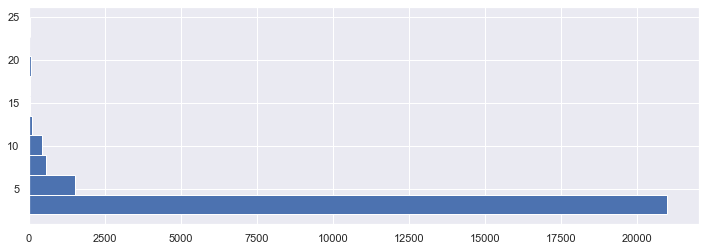

In [7]:
plt.figure(figsize=(12, 4))
# plot excluding only review once
plt.hist(df[df.review_times > 1].review_times, orientation='horizontal')
plt.show()

## 2. Difference on _Product Ratings_

In [8]:
tmp = df.assign(binary=lambda df: df.review_times.apply(lambda d: 'once' if d == 1 else 'more'))
tmp.binary.value_counts()

once    91576
more    23765
Name: binary, dtype: int64

In [9]:
tmp[tmp.binary =='once'].star_rating.describe()
# note mean is lower, 25% quantile at 4

count    91576.000000
mean         4.389425
std          1.166922
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: star_rating, dtype: float64

In [10]:
tmp[tmp.binary =='more'].star_rating.describe()
# 25% quantile at 5

count    23765.000000
mean         4.543362
std          0.958413
min          1.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: star_rating, dtype: float64

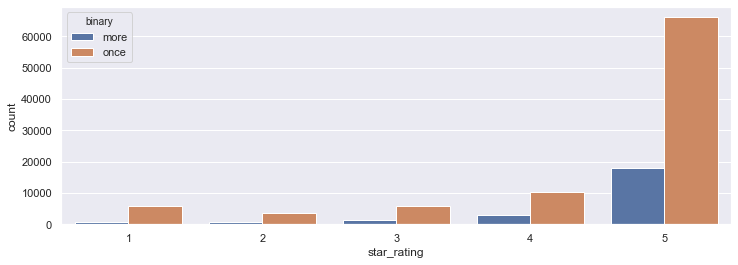

In [11]:
plt.figure(figsize=(12, 4))
df.assign(binary=lambda df: df.review_times.apply(lambda d: 'once' if d == 1 else 'more'))\
    .pipe((sns.countplot, 'data'), x='star_rating', hue='binary', )
plt.show()
# count plot with counts

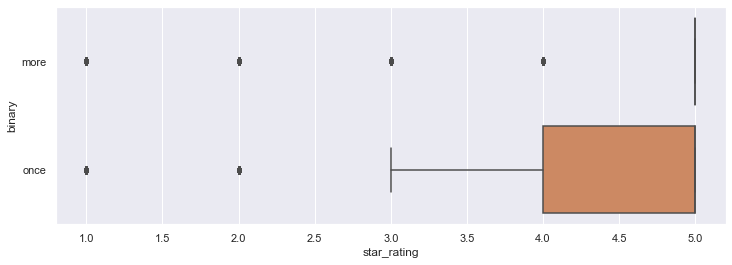

In [12]:
plt.figure(figsize=(12, 4))
df.assign(binary=lambda df: df.review_times.apply(lambda d: 'once' if d == 1 else 'more'))\
    .pipe((sns.boxplot, 'data'), x='star_rating', y='binary')
# plt.savefig('./figures/return_rating-box.png', bbox_inches='tight', dpi=300)
plt.show()
# no difference in rating

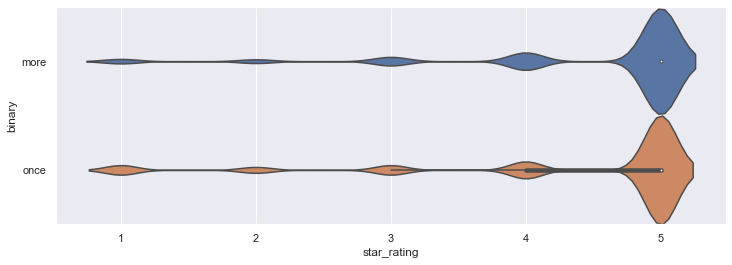

In [13]:
plt.figure(figsize=(12, 4))
df.assign(binary=lambda df: df.review_times.apply(lambda d: 'once' if d == 1 else 'more'))\
    .pipe((sns.violinplot, 'data'), x='star_rating', y='binary', scale='area', width=1.)
# plt.savefig('./figures/return_rating-violin.png', bbox_inches='tight', dpi=300)
plt.show()
# no difference in rating

## 3. Difference on Product Nutrients

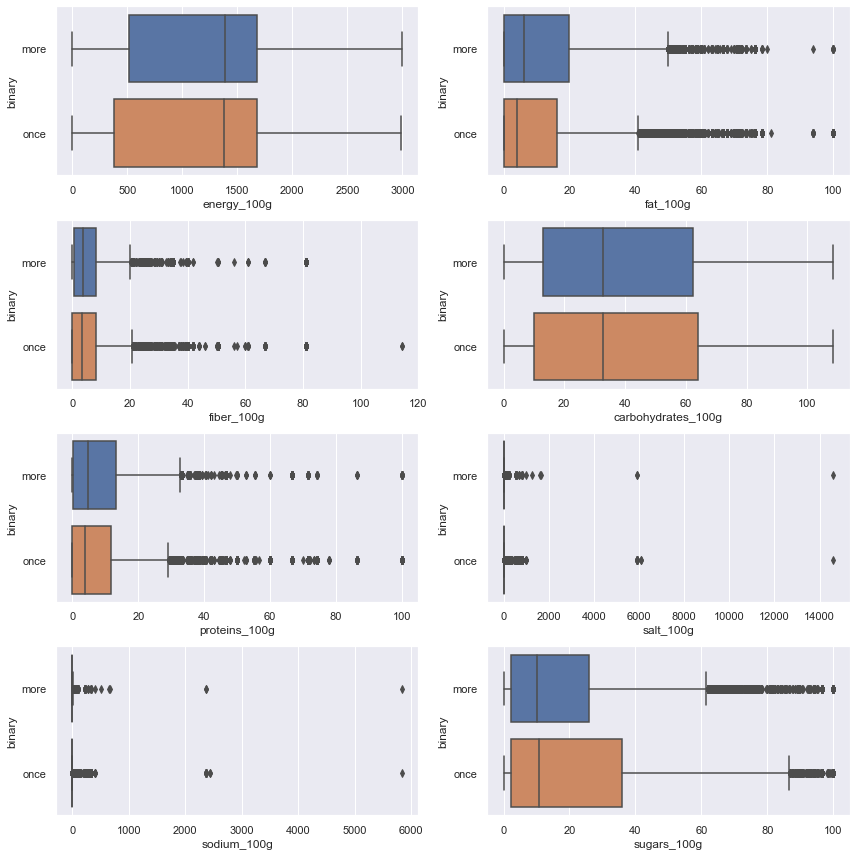

In [14]:
tmp = df.assign(binary=lambda df: df.review_times.apply(lambda d: 'once' if d == 1 else 'more'))
nutrients = ['energy_100g', 'fat_100g', 'fiber_100g', 'carbohydrates_100g', 
             'proteins_100g', 'salt_100g', 'sodium_100g', 'sugars_100g']

fig, axs = plt.subplots(4,2, figsize=(12, 12), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(8):
    sns.boxplot(x=nutrients[i], y='binary', data=tmp, ax=axs[i])
plt.tight_layout()
# plt.savefig('./figures/return_nutrients.png', bbox_inches='tight', dpi=300)
plt.show()
# only some difference in sugar content

## 4. Difference on Review Length

In [22]:
func = lambda s:  0 if s is None else len(s.split(' '))
tmp = df.assign(review_len=lambda df: df.review_body.apply(func))

tmp.review_len.describe()

count    115341.000000
mean         36.733148
std          44.651252
min           0.000000
25%          11.000000
50%          25.000000
75%          45.000000
max        1439.000000
Name: review_len, dtype: float64

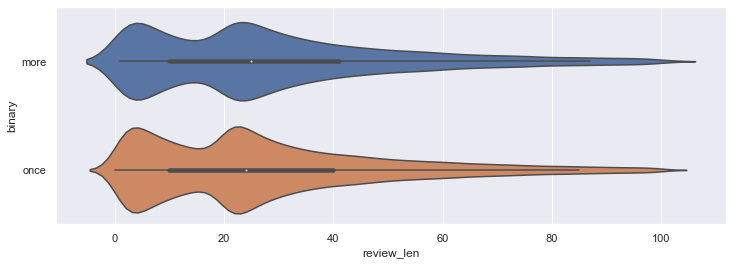

In [24]:
# having outliers, set a limit by 100
plt.figure(figsize=(12, 4))

tmp.query('review_len <= 100')\
    .pipe((sns.violinplot, 'data'), x='review_len', y='binary')
# plt.savefig('./figures/return_review-length.png', bbox_inches='tight', dpi=300)
plt.show()
# no difference in rating

## 5. Difference on Words used in Reviews
+ https://www.datacamp.com/community/tutorials/wordcloud-python
+ https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911
+ to Lollipop Chart

In [25]:
import re
import json
from collections import Counter
from nltk.corpus import stopwords
# from nltk.tokenize import TweetTokenizer

In [26]:
sql = \
"""
SELECT 
    review_id, customer_id, review_body
FROM 
    food_reviews
WHERE 
    energy_100g IS NOT NULL
    AND energy_100g < 3000
    AND review_date >= '2010-01-01'
    AND verified_purchase LIKE 'Y'
"""
df = pd.read_sql(sql, con=engine)\
    .assign(review_times=lambda df: df.groupby('customer_id')[['review_id']].transform('count'))\
    .assign(binary=lambda df: df.review_times.apply(lambda d: 'once' if d == 1 else 'more'))
df.shape

(115341, 5)

In [27]:
stopWords = set(stopwords.words('english')) # 179 originally
commonWords = ["br"]
stopWords.update(commonWords)
# stopWords
len(stopWords)

180

In [28]:
# build review strings by each group
text_once = []
text_more = []
for row in df.itertuples():
    if (row.binary == 'once') & (row.review_body is not None):
        for word in re.split(r'\W+', row.review_body.lower()):
            if (word not in stopWords) & (word != ""): 
                text_once.append(word)
    elif (row.binary == 'more') & (row.review_body is not None):
        for word in re.split(r'\W+', row.review_body.lower()):
            if (word not in stopWords) & (word != ""): 
                text_more.append(word)
                
counterOnce = Counter(text_once)
counterMore = Counter(text_more)
len(text_once), len(text_more)

(1639462, 469124)

Sorted by Percentage, ascending
```python
sorted([(c, counterOnce[c] / len(text_once) * 100.0) for c in counterOnce], 
       key=lambda d: d[1], reverse=True)[:10]

sorted([(c, counterMore[c] / len(text_more) * 100.0) for c in counterMore], 
       key=lambda d: d[1], reverse=True)[:10]
```

return json as:   
`{'more':[{word: , value: }], 'once': [{word: , value: }]}`

In [42]:
# if output the percentage of a token
pctOnce = sorted([(c, counterOnce[c] / len(text_once) * 100.0) for c in counterOnce], 
                 key=lambda d: d[1], reverse=True)
pctMore = sorted([(c, counterMore[c] / len(text_more) * 100.0) for c in counterMore], 
                 key=lambda d: d[1], reverse=True)

d = {'once': [{'word': w, 'value': v} for (w, v) in pctOnce], 
     'more': [{'word': w, 'value': v} for (w, v) in pctMore] }

```python
# if output the count of a token 
d = {'once': [{'word': w, 'value': v} for (w, v) in counterOnce.items()], 
     'more': [{'word': w, 'value': v} for (w, v) in counterMore.items()] }
```

In [43]:
# reduce size to 5000
d['once'] = d['once'][:5000]
d['more'] = d['more'][:5000]

In [44]:
#dump as a long string
# json.dumps(d)

# dump to a file
# as objects in file
with open('returning_words.json', 'w', encoding='utf-8') as f:
    json.dump(d, f, ensure_ascii=False, indent=4)

## Users' Time of Review
+ Output data for rigeline chart
+ "when to leave a review"
+ x-axis: day of a week
+ y-axis: category of times a user leaving a review
+ value: smoothed p value on review counts

In [85]:
start_date = '2014-01-01'
end_date = '2014-12-31'

In [86]:
query = \
"""
SELECT 
    customer_id,
    review_id, 
    review_date
FROM 
    food_reviews
WHERE 
    verified_purchase LIKE 'Y'
    AND review_date IS NOT NULL
    AND review_date BETWEEN '{0}' AND '{1}'
ORDER BY
    review_date
""".format(start_date, end_date)
sub = pd.read_sql(query, con=engine)
sub.shape

(38254, 3)

In [96]:
# 3 to 11
n_times = 6

In [97]:
index = []
for times in range(1, n_times):
    for weekday in range(7):
        index.append((times, weekday))
len(index) # (number of category) * (number of days)

14

In [98]:
# more than 10 times, reset as 10
data = sub.assign(times=lambda df: df.groupby('customer_id')[['review_id']].transform('count'))\
    .assign(times=lambda df: np.where(df.times >= n_times-1, n_times-1, df.times))\
    .groupby(['times', sub.review_date.dt.dayofweek])[['review_id']].count()\
    .reindex(index, fill_value=0)\
    .reset_index(drop=False)\
    .assign(byTimesSum=lambda d: d.groupby('times')[['review_id']].transform('sum'))\
    .assign(p=lambda d: d.review_id / d.byTimesSum)\
    .assign(byTimesMaxP=lambda d: d.groupby('times')[['p']].transform(max))\
    .assign(p_peak=lambda d: d.p / d.byTimesMaxP)\
    .assign(p_lag1=lambda d: d.groupby('times')[['p_peak']].shift(-1))\
    .assign(p_lead1=lambda d: d.groupby('times')[['p_peak']].shift(1))\
    .assign(p_smooth=lambda d: (d.p_lag1 + d.p_peak + d.p_lead1) / 3)\
    .drop(['review_id', 'byTimesSum', 'byTimesMaxP', 'p_lag1', 'p_lead1',], axis=1)\
    .rename(columns={'times': 'review_times', 'review_date': 'weekday'})\
    .fillna(method='ffill', axis=1)

In [99]:
# sample for first 3 rows
data.iloc[:3, :].to_json(orient='records')
# data.to_json('local.json', orient='records', )

'[{"review_times":1.0,"weekday":0.0,"p":0.1544062733,"p_peak":1.0,"p_smooth":1.0},{"review_times":1.0,"weekday":1.0,"p":0.1509833209,"p_peak":0.9778315195,"p_smooth":0.9863630257},{"review_times":1.0,"weekday":2.0,"p":0.1515123226,"p_peak":0.9812575574,"p_smooth":0.9639930136}]'